In [1]:
# ------------------- Vigenre Cipher ------------------

In [2]:
import math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
# from caas_jupyter_tools import display_dataframe_to_user

In [3]:
random.seed(42)
np.random.seed(42)

ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

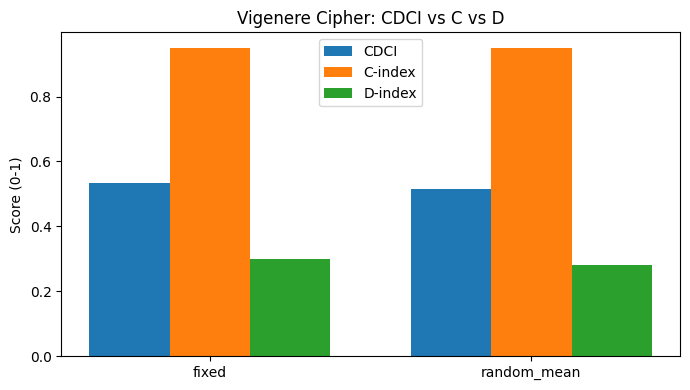

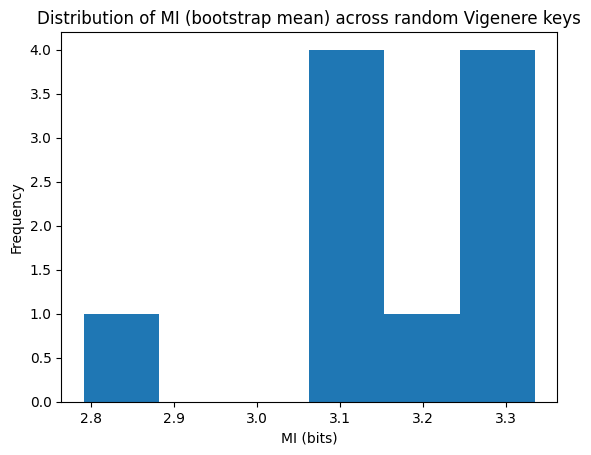

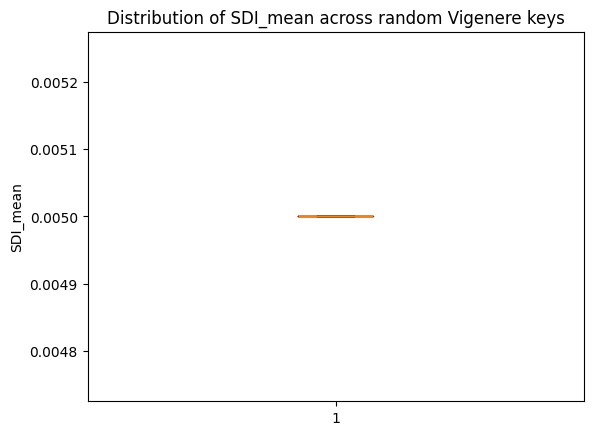

CSV files saved: vigenere_cipher_fixed.csv, vigenere_cipher_random.csv, vigenere_cipher_summary.csv


In [5]:
# ---------------- Vigenere Cipher ----------------
def vigenere_encrypt(text, key):
    text = "".join(ch for ch in text.upper() if 'A' <= ch <= 'Z')
    key = key.upper()
    out=[]
    for i,ch in enumerate(text):
        shift = ord(key[i % len(key)]) - 65
        out.append(chr(((ord(ch)-65 + shift) % 26) + 65))
    return "".join(out)

def random_vigenere_key(min_len=3, max_len=7):
    length = random.randint(min_len, max_len)
    return "".join(random.choice(ALPHABET) for _ in range(length))

def perturb_vigenere_key(key):
    pos = random.randrange(len(key))
    new_char = random.choice([c for c in ALPHABET if c != key[pos]])
    return key[:pos] + new_char + key[pos+1:]

# ---------------- Metric Functions (reuse from earlier) ----------------
def fraction_changed(a, b):
    return sum(x!=y for x,y in zip(a,b)) / len(a)

def symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials=10):
    L = len(plaintext)
    C = cipher_func(plaintext, key)
    results = []
    for _ in range(trials):
        i = random.randrange(L)
        new_char = random.choice([c for c in alphabet if c != plaintext[i]])
        P2 = plaintext[:i]+new_char+plaintext[i+1:]
        C2 = cipher_func(P2, key)
        results.append(fraction_changed(C, C2))
    return np.mean(results), np.std(results)

def compute_ksi(cipher_func, plaintext, key, key_variant):
    C = cipher_func(plaintext, key)
    C2 = cipher_func(plaintext, key_variant)
    return fraction_changed(C, C2)

def mutual_information(pairs):
    N = len(pairs)
    joint = Counter(pairs)
    X_counts = Counter(x for x,_ in pairs)
    Y_counts = Counter(y for _,y in pairs)
    mi = 0.0
    for (x,y), n in joint.items():
        p_xy = n/N
        p_x = X_counts[x]/N
        p_y = Y_counts[y]/N
        mi += p_xy * math.log2(p_xy/(p_x*p_y))
    return mi

def compute_mi_from_plain_cipher_lists(plain_list, cipher_list):
    pairs = list(zip("".join(plain_list), "".join(cipher_list)))
    return mutual_information(pairs)

def compute_chi_entropy(ciphertexts, alphabet):
    text = "".join(ciphertexts)
    N = len(text)
    counts = Counter(text)
    expected = N/len(alphabet)
    chi2 = sum((counts[a]-expected)**2/expected for a in alphabet)
    entropy = -sum((counts[a]/N)*math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2, entropy

def bootstrap_mi(pairs, n_boot=200, alpha=0.05):
    estimates=[]
    N = len(pairs)
    for _ in range(n_boot):
        sample = [pairs[random.randrange(N)] for _ in range(N)]
        mi = mutual_information(sample)
        estimates.append(mi)
    estimates.sort()
    low = estimates[int((alpha/2)*n_boot)]
    high= estimates[int((1-alpha/2)*n_boot)]
    return np.mean(estimates), (low,high)

# ---------------- CDCI ----------------
def confusion_index(cipher_func, plaintext, keyspace, samples=100):
    pairs = []
    for _ in range(samples):
        k = random.choice(keyspace)
        c = cipher_func(plaintext, k)
        for sym in c:
            pairs.append((str(k), sym))
    mi = mutual_information(pairs)
    H_K = math.log2(len(keyspace))
    C = 1 - (mi / H_K if H_K>0 else 0)
    return max(0, min(1, C))

def ciphertext_entropy_one(cipher_func, plaintext, key):
    C = cipher_func(plaintext, key)
    chi2, Hc = compute_chi_entropy([C], ALPHABET)
    return Hc

def diffusion_index(cipher_func, plaintext, key, alphabet, alpha=0.7, trials=10):
    sdi_mean, sdi_std = symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials)
    Hc = ciphertext_entropy_one(cipher_func, plaintext, key)
    norm_H = Hc / math.log2(len(alphabet))
    D = alpha*sdi_mean + (1-alpha)*norm_H
    return D, sdi_mean, sdi_std, norm_H

def cdci_score(cipher_func, plaintext, key, keyspace, alphabet, alpha=0.7):
    C = confusion_index(cipher_func, plaintext, keyspace)
    D, sdi_mean, sdi_std, norm_H = diffusion_index(cipher_func, plaintext, key, alphabet, alpha=alpha)
    return math.sqrt(C*D), C, D, sdi_mean, sdi_std, norm_H

# ---------------- Experiment ----------------
num_texts = 5
length = 200
plaintexts = ["".join(random.choice(ALPHABET) for _ in range(length)) for _ in range(num_texts)]
plaintexts[0] = ("THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG" * 6)[:length]

fixed_key = "KEY"
random_key_count = 10
random_keys = [random_vigenere_key() for _ in range(random_key_count)]
keyspace_for_confusion = [random_vigenere_key() for _ in range(50)]  # subset sample

# --- Mode A: Fixed Key ---
fixed_results = {}
sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; entropy_vals=[]; mi_boot_means=[]; mi_boot_cis=[]
for pt in plaintexts:
    sdi_mean,_ = symbol_diffusion_index(vigenere_encrypt, pt, fixed_key, ALPHABET, trials=20)
    sdi_vals.append(sdi_mean)
    ksi_vals.append(compute_ksi(vigenere_encrypt, pt, fixed_key, perturb_vigenere_key(fixed_key)))
    Ctext = vigenere_encrypt(pt, fixed_key)
    mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[Ctext]))
    chi2,Hc = compute_chi_entropy([Ctext], ALPHABET)
    chi_vals.append(chi2); entropy_vals.append(Hc)
    mean_boot, ci = bootstrap_mi(list(zip(pt,Ctext)), n_boot=100)
    mi_boot_means.append(mean_boot); mi_boot_cis.append(ci)

fixed_results['SDI_mean']=np.mean(sdi_vals)
fixed_results['KSI_mean']=np.mean(ksi_vals)
fixed_results['MI_mean']=np.mean(mi_vals)
fixed_results['Chi2_mean']=np.mean(chi_vals)
fixed_results['Entropy_mean']=np.mean(entropy_vals)
fixed_results['MI_boot_mean']=np.mean(mi_boot_means)
fixed_results['MI_boot_CI_low']=np.mean([ci[0] for ci in mi_boot_cis])
fixed_results['MI_boot_CI_high']=np.mean([ci[1] for ci in mi_boot_cis])
fixed_cdci,fixed_C,fixed_D,_,_,_ = cdci_score(vigenere_encrypt, plaintexts[0], fixed_key, keyspace_for_confusion, ALPHABET)
fixed_results['CDCI']=fixed_cdci; fixed_results['C_index']=fixed_C; fixed_results['D_index']=fixed_D

fixed_df = pd.DataFrame([fixed_results])

# --- Mode B: Random Keys ---
random_mode_results=[]
for rk in random_keys:
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; entropy_vals=[]; mi_boot_means=[]
    for pt in plaintexts:
        sdi_mean,_ = symbol_diffusion_index(vigenere_encrypt, pt, rk, ALPHABET, trials=12)
        sdi_vals.append(sdi_mean)
        ksi_vals.append(compute_ksi(vigenere_encrypt, pt, rk, perturb_vigenere_key(rk)))
        Ctext=vigenere_encrypt(pt,rk)
        mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[Ctext]))
        chi2,Hc=compute_chi_entropy([Ctext],ALPHABET)
        chi_vals.append(chi2); entropy_vals.append(Hc)
        mean_boot,_=bootstrap_mi(list(zip(pt,Ctext)),n_boot=80)
        mi_boot_means.append(mean_boot)
    CDCI,C,D,_,_,_ = cdci_score(vigenere_encrypt, plaintexts[0], rk, keyspace_for_confusion, ALPHABET)
    random_mode_results.append({
        'key':rk,'SDI_mean':np.mean(sdi_vals),
        'KSI_mean':np.mean(ksi_vals),'MI_mean':np.mean(mi_vals),
        'Chi2_mean':np.mean(chi_vals),'Entropy_mean':np.mean(entropy_vals),
        'MI_boot_mean':np.mean(mi_boot_means),'CDCI':CDCI,'C_index':C,'D_index':D
    })
random_df=pd.DataFrame(random_mode_results)

summary=pd.DataFrame({
    'mode':['fixed','random_mean'],
    'SDI_mean':[fixed_results['SDI_mean'],random_df['SDI_mean'].mean()],
    'KSI_mean':[fixed_results['KSI_mean'],random_df['KSI_mean'].mean()],
    'MI_mean':[fixed_results['MI_mean'],random_df['MI_mean'].mean()],
    'Entropy_mean':[fixed_results['Entropy_mean'],random_df['Entropy_mean'].mean()],
    'CDCI':[fixed_results['CDCI'],random_df['CDCI'].mean()],
    'C_index':[fixed_results['C_index'],random_df['C_index'].mean()],
    'D_index':[fixed_results['D_index'],random_df['D_index'].mean()],
})

# ---------------- Outputs ----------------
# display_dataframe_to_user("Vigenere Cipher - Fixed Key Results", fixed_df)
# display_dataframe_to_user("Vigenere Cipher - Random Keys Results", random_df)
# display_dataframe_to_user("Vigenere Cipher - Summary", summary)

# Plots
labels=summary['mode']; x=np.arange(len(labels)); width=0.25
fig,ax=plt.subplots(figsize=(7,4))
ax.bar(x-width,summary['CDCI'],width,label='CDCI')
ax.bar(x,summary['C_index'],width,label='C-index')
ax.bar(x+width,summary['D_index'],width,label='D-index')
ax.set_xticks(x); ax.set_xticklabels(labels); ax.set_ylabel('Score (0-1)')
ax.set_title('Vigenere Cipher: CDCI vs C vs D'); ax.legend(); plt.tight_layout(); plt.show()

plt.hist(random_df['MI_boot_mean'],bins=6)
plt.title('Distribution of MI (bootstrap mean) across random Vigenere keys')
plt.xlabel('MI (bits)'); plt.ylabel('Frequency'); plt.show()

plt.boxplot(random_df['SDI_mean'].dropna())
plt.title('Distribution of SDI_mean across random Vigenere keys')
plt.ylabel('SDI_mean'); plt.show()

# Save CSVs
fixed_df.to_csv('./data/vigenere_cipher_fixed.csv',index=False)
random_df.to_csv('./data/vigenere_cipher_random.csv',index=False)
summary.to_csv('./data/vigenere_cipher_summary.csv',index=False)
print("CSV files saved: vigenere_cipher_fixed.csv, vigenere_cipher_random.csv, vigenere_cipher_summary.csv")

In [6]:
fixed_df

,SDI_mean,KSI_mean,MI_mean,Chi2_mean,Entropy_mean,MI_boot_mean,MI_boot_CI_low,MI_boot_CI_high,CDCI,C_index,D_index
0,0.005,0.334,3.195896,19.336,4.629054,3.30356,3.204576,3.416939,0.53345,0.950641,0.299344


In [7]:
random_df

,key,SDI_mean,KSI_mean,MI_mean,Chi2_mean,Entropy_mean,MI_boot_mean,CDCI,C_index,D_index
0,OPMJ,0.005,0.250,2.893855,19.960,4.626505,3.073757,0.530728,0.942131,0.298973
1,DDBJR,0.005,0.200,3.143001,58.076,4.459434,3.256421,0.494714,0.951096,0.257326
2,SAZ,0.005,0.333,3.199837,18.036,4.632995,3.302790,0.533124,0.948845,0.299544
3,JNONOF,0.005,0.166,2.950862,21.052,4.621632,3.120731,0.534712,0.949664,0.301071
4,OBZVB,0.005,0.200,3.231564,40.136,4.530913,3.334635,0.508977,0.941206,0.275240
5,TOJLQZ,0.005,0.166,2.485459,17.672,4.634855,2.791002,0.534552,0.948307,0.301322
6,GTEECFE,0.005,0.142,3.073942,50.432,4.506734,3.219533,0.503954,0.958245,0.265036
7,COYWS,0.005,0.200,2.945475,50.484,4.490869,3.106630,0.498168,0.952666,0.260502
8,UAKMQ,0.005,0.200,2.933858,52.876,4.479252,3.093317,0.494635,0.945356,0.258806
9,KUE,0.005,0.334,3.185445,22.612,4.618603,3.292011,0.530937,0.949543,0.296873


In [8]:
summary

,mode,SDI_mean,KSI_mean,MI_mean,Entropy_mean,CDCI,C_index,D_index
0,fixed,0.005,0.3340,3.195896,4.629054,0.53345,0.950641,0.299344
1,random_mean,0.005,0.2191,3.004330,4.560179,0.51645,0.948706,0.281469
